# Computer Vision - Human Faces Detection

---

**Reference**\
The implementation in this notebook was adapted from the Udemy course [Deep Learning: Advanced Computer Vision (GANs, SSD, +More!)](https://www.udemy.com/course/advanced-computer-vision/) by LazyProgrammer

---

In this notebook we will:

1. Install the RetinaNet
2. Prepare a dataset with annotated human faces
3. Preprocess the data, annotations, and class mapping
4. Train the RetinaNet
5. See and evaluate the performance of the model

---

## RetinaNet

**Original paper:**

Lin et al., Focal Loss for dense object detection [arXiv](https://arxiv.org/abs/1708.02002)

**Pre-trained model**

The weights of the pre-trained RetinaNet on Keras can be downloaded from this GitHub repository: [github (Fizyr)](https://github.com/fizyr/keras-retinanet)

## Step 1: Install RetinaNet and import libraries

First we clone the RetinaNet repository and install the package.

In [1]:
## Clone the retinanet repository
!git clone https://github.com/fizyr/keras-retinanet.git

## Install keras-retinanet
%cd keras-retinanet/
!pip install .

## Compile Cython codes
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 13.48 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (4196/4196), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168079 sha256=14394e33fef2e823bb67464395e00a61c8f2ed0dac7fb59e782b175ae952eb71
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=2bc48609232c04befb9f9f499bb85a7b2424d782d2f2dde6423aee6d5afd857e
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet kera

In [2]:
## import libraries

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import urllib

from sklearn.model_selection import train_test_split

from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

## Step 2: Prepare the dataset

The dataset comes from the Udemy course [Deep Learning: Advanced Computer Vision (GANs, SSD, +More!)](https://www.udemy.com/course/advanced-computer-vision/) by LazyProgrammer.

I downloaded the file `face_detection.json` from the instructor's personal website.

The file contains:

1. URLs of 409 images, and
2. The annotated bounding boxes of the faces in each image

In [3]:
## Download the dataset
%cd  ..
!wget -nc https://lazyprogrammer.me/course_files/face_detection.json

/content
--2020-11-04 23:12:34--  https://lazyprogrammer.me/course_files/face_detection.json
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273830 (267K) [application/json]
Saving to: ‘face_detection.json’

face_detection.json 100%[===================>] 267.41K   446KB/s    in 0.6s    

2020-11-04 23:12:35 (446 KB/s) - ‘face_detection.json’ saved [273830/273830]



In [4]:
## Use the Linux command !head to see the top 10 rows
!head face_detection.json

{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e00

In [5]:
## Load the first row

import json

j = json.loads(open('face_detection.json').readline())

j

{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

### Load the data into pd.DataFrame

In [6]:
## Load the whole face_detection.json as a pd.dataframe

# `lines = True` sets to read the file as a json object per line

df = pd.read_json('face_detection.json', lines = True)

print("df's shape: {}".format(df.shape))

df.head()

df's shape: (409, 3)


,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


### See an image and annotated bounding boxes

Image index: 30
Number of faces: 2


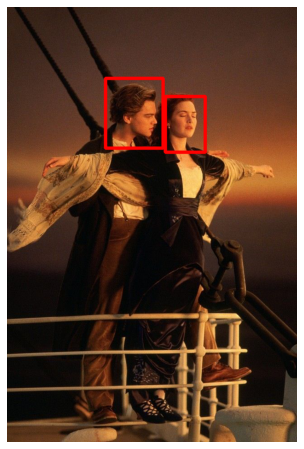

In [7]:
## See an image

# visit the image html and download to local work directory

# use request.get(<html>), where the <html> are listed in the df['content']

image_index = 30

print("Image index: {}".format(image_index))

r = requests.get(df['content'][image_index])

face_annotations = df['annotation'][image_index] # a list of face annotations in the image

print("Number of faces: {}".format(len(face_annotations)))

with open('sample_image.jpg', 'wb') as f:
    f.write(r.content)

sample_image = np.array(Image.open('sample_image.jpg'))
sample_image = sample_image[:, :, :3]

for face_i_annotation in face_annotations:

    bbox_info = face_i_annotation['points']
    img_width = face_i_annotation['imageWidth']
    img_height = face_i_annotation['imageHeight']

    xmin = round(bbox_info[0]['x']*img_width)
    xmax = round(bbox_info[1]['x']*img_width)
    ymin = round(bbox_info[0]['y']*img_height)
    ymax = round(bbox_info[1]['y']*img_height)

    bbox = [xmin, ymin, xmax, ymax]

    draw_box(sample_image, bbox, color = (255, 0, 0), thickness = 5)

plt.figure(figsize = (8,8))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

## Step 3: Preprocess the data and the annotations

To train the RetinaNet, the annotations (the actual locations of the bounding boxes) should have a certain format. According the [instruction](https://github.com/fizyr/keras-retinanet#annotations-format) on Github, the format of annotations should be:

```
path_to_image.jpg,x1,y1,x2,y2,class_name
```

where each row contains the information of a single object we want to detect

We use dictionaries to cache the information first, and later save it into a .csv file

The dictionaries contain:

- the image name
- (x_min, y_min, x_max, y_max) of the bounding box
- the class of the object (which is `face` for all objects)

In [8]:
## Create an empty dictionary

converted_data_train = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

converted_data_test = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

### 3-1 Helper functions to download the images

The function `map_to_data` downloads the images according to the URL and save it to the `faces` folder

In [9]:
## Create a folder to save images

if not os.path.exists('faces'):
  os.mkdir('faces')

In [10]:
## Sequentially download the images and save to the 'faces' folder

idx = 0

def map_to_data(row, converted_data):

    global idx
    r = requests.get(row['content'])
    filepath = 'faces/face_%s.jpg' % idx

    if not os.path.exists(filepath):
        with open(filepath, 'wb') as f:
            f.write(r.content)

    for anno in row['annotation']:
        converted_data['image_name'].append(filepath)

        width = anno['imageWidth']
        height = anno['imageHeight']

        x1 = int(round(anno['points'][0]['x'] * width))
        y1 = int(round(anno['points'][0]['y'] * height))
        x2 = int(round(anno['points'][1]['x'] * width))
        y2 = int(round(anno['points'][1]['y'] * height))

        converted_data['x_min'].append(x1)
        converted_data['x_max'].append(x2)
        converted_data['y_min'].append(y1)
        converted_data['y_max'].append(y2)

        converted_data['class_name'].append('face')

    idx += 1

### 3-2 Split data into training and test data

In [11]:
train_df, test_df = train_test_split(df, test_size = 0.2)

Use the `apply()` method to map every row in `train_df` and `test_df` through the function `map_to_data` to update `converted_data_train` and `converted_data_test`

### 3-3 Download the training and test data

In [12]:
idx = 0 # to assert the idx is zeroed

train_df.apply(lambda row: map_to_data(row, converted_data_train), axis = 1)
test_df.apply(lambda row: map_to_data(row, converted_data_test), axis = 1)

192    None
77     None
230    None
354    None
405    None
       ... 
327    None
102    None
355    None
47     None
115    None
Length: 82, dtype: object

### 3-4 Convert `converted_data_train` and `converted_data_test` to pd.DataFrame

In [13]:
# Convert converted_data_train to train_df
train_df = pd.DataFrame(converted_data_train)
# Convert converted_data_test to test_df
test_df = pd.DataFrame(converted_data_test)

In [14]:
# train_df
print("train_df: shape = {}".format(train_df.shape))
train_df.head()

train_df: shape = (890, 6)


,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_0.jpg,337,86,412,168,face
1,faces/face_1.jpg,288,35,463,229,face
2,faces/face_2.jpg,35,11,196,178,face
3,faces/face_2.jpg,401,92,516,244,face
4,faces/face_2.jpg,712,54,880,270,face


In [42]:
# unique images in train_df
train_df['image_name'].unique().shape

(327,)

In [15]:
# test_df
print("test_df: shape = {}".format(test_df.shape))
test_df.head()

test_df: shape = (242, 6)


,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_327.jpg,129,249,417,594,face
1,faces/face_327.jpg,429,17,595,250,face
2,faces/face_327.jpg,618,54,824,277,face
3,faces/face_327.jpg,729,291,1008,653,face
4,faces/face_328.jpg,420,0,550,124,face


Note that in an image where there are multiple bounding boxes, each bounding box is listed by individual rows:

In [16]:
train_df[train_df['image_name'] == 'faces/face_0.jpg']

,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_0.jpg,337,86,412,168,face


In [17]:
## Helper function to sample an image randomly and display it with its bounding boxes

def show_image_with_boxes(df):

    """
    Sample an image randomly. Plot the images and all the bounding boxes within

    Inout:
            df - the pd.DataFrame. Columns: {image_name, x_min, y_min, x_max, y_max, class_name}
    """

    img_file_path = df.sample()['image_name'].values[0]

    print(img_file_path)

    img_df = df[df['image_name'] == img_file_path]

    img = np.array(Image.open(img_file_path))

    # make sure the only d=3 in the last dimension (neglecting alpha)
    img = img[:,:,:3] 

    for _, x in img_df.iterrows():
        bbox = [x['x_min'], x['y_min'], x['x_max'], x['y_max']]
        print(bbox)

        draw_box(img, bbox, color = (255, 0, 0))

    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.show()

faces/face_208.jpg
[182, 15, 242, 103]
[364, 100, 458, 178]


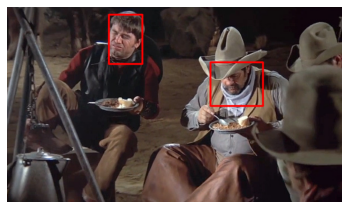

In [18]:
show_image_with_boxes(train_df)

### 3-5 Save the training data into csv file

In [19]:
train_df.to_csv('annotations.csv', index = False, header = None)

# Check format
!head annotations.csv

faces/face_0.jpg,337,86,412,168,face
faces/face_1.jpg,288,35,463,229,face
faces/face_2.jpg,35,11,196,178,face
faces/face_2.jpg,401,92,516,244,face
faces/face_2.jpg,712,54,880,270,face
faces/face_2.jpg,624,88,683,197,face
faces/face_2.jpg,547,98,587,161,face
faces/face_2.jpg,8,12,34,95,face
faces/face_3.jpg,307,405,481,615,face
faces/face_3.jpg,345,102,499,288,face


### 3-6 Create vlass mapping file

To train the RetinaNet, we need a file to specify the ID for each class

https://github.com/fizyr/keras-retinanet#class-mapping-format

The format looks like:

```
class-name,id
```

In out case, we only need 1 line:

```
face, 0
```

In [20]:
## Create class.csv and write a single row 'face', 0

classes = ['face']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name}, {i}\n')

# check format
!head classes.csv

face, 0


## Step 4: Train the RetinaNet

### 4-1 Create a folder to save pre-trained weights and checkpoints

In [21]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

### 4-2 Download the pre-trained RetinaNet model

Available models released are listed in [this page](https://github.com/fizyr/keras-retinanet/releases)

In [36]:
# pre-trained model file name
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

# the URL
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

# download the model
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Pretrained model downloaded to {}'.format(PRETRAINED_MODEL))

Pretrained model downloaded to snapshots/_pretrained_model.h5


In [37]:
!ls keras-retinanet

build		 images		  README.md	    setup.py
CONTRIBUTORS.md  keras_retinanet  requirements.txt  snapshots
examples	 LICENSE	  setup.cfg	    tests


### 4-3 Training

In [43]:
!keras-retinanet/keras_retinanet/bin/train.py \
--freeze-backbone \
--random-transform \
--weights {PRETRAINED_MODEL} \
--batch-size 8 \
--steps 40 \
--epochs 20 \
csv annotations.csv classes.csv

2020-11-05 00:20:15.543760: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-11-05 00:20:17.185442: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-05 00:20:17.191714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-05 00:20:17.192246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-11-05 00:20:17.192292: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-05 00:20:17

In [44]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_07.h5  resnet50_csv_14.h5
resnet50_csv_01.h5    resnet50_csv_08.h5  resnet50_csv_15.h5
resnet50_csv_02.h5    resnet50_csv_09.h5  resnet50_csv_16.h5
resnet50_csv_03.h5    resnet50_csv_10.h5  resnet50_csv_17.h5
resnet50_csv_04.h5    resnet50_csv_11.h5  resnet50_csv_18.h5
resnet50_csv_05.h5    resnet50_csv_12.h5  resnet50_csv_19.h5
resnet50_csv_06.h5    resnet50_csv_13.h5  resnet50_csv_20.h5


In [45]:
from glob import glob


model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path: ", latest_path)

model = models.load_model(latest_path, backbone_name = 'resnet50')
model = models.convert_model(model)

label_map = {}


for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path:  snapshots/resnet50_csv_20.h5


In [46]:
def show_image_with_predictions(df, threshold = 0.6):
  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape", im.shape)

  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
    print(box)
    draw_box(im, box, color = (255,0,0))

  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(imp, axis = 0))

  boxes /= scale

  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < threshold:
      break
    
    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color)

    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)
  
  plt.axis('off')
  plt.imshow(im)
  plt.show()

plt.rcParams['figure.figsize'] = [20, 10]

filepath: faces/face_228.jpg
im.shape (650, 1250, 3)
[607, 45, 689, 134]
[130, 471, 228, 608]
[990, 85, 1071, 168]
[157, 138, 241, 217]
[43, 64, 131, 134]
[343, 93, 413, 167]
[932, 436, 1008, 520]
[435, 158, 516, 225]


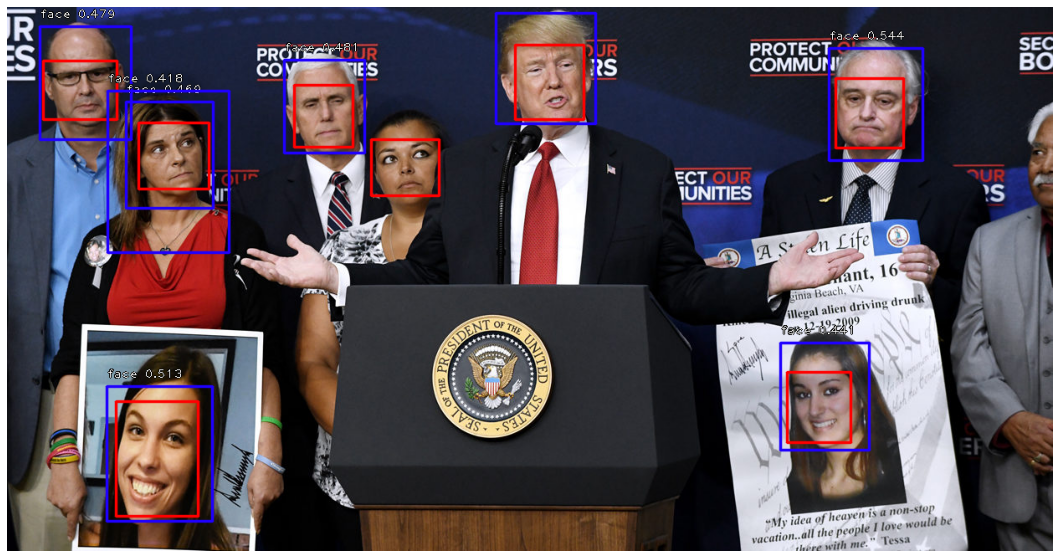

In [52]:
show_image_with_predictions(train_df, threshold = 0.4)